In [1]:

import numpy as np
import tensorflow as tf


In [4]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import re

In [6]:

from sklearn.model_selection import train_test_split
import re
import pickle
from collections import defaultdict


In [24]:

# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text



# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized







# Function to remove emojis and special characters from Arabic text
def ar_remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    # Remove special characters (retain Arabic letters and Arabic numbers)
    text = re.sub(r'[^\u0600-\u06FF0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

# Preprocessing pipeline
def ar_preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = ar_remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        tokenized.append(sentence)
    return tokenized






from IPython.display import HTML
import keras

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words


def predict_and_display_top_five_words(seed_text, model, tokenizer):

    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """
    return HTML(javascript_code)




def update_model_with_feedback(model, tokenizer, feedback_text, seed_text, learning_rate=0.001, batch_size=32, epochs=1):
    # Tokenize the feedback text
    sequence = tokenizer.texts_to_sequences([feedback_text])[0]

    # Tokenize the seed text
    seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]

    # Prepare input sequence and target
    input_sequence = pad_sequences([seed_sequence], maxlen=len(seed_sequence), padding='pre')
    target = tf.keras.utils.to_categorical([sequence[-1]], num_classes=len(tokenizer.word_index) + 1)

    # Compile the model with appropriate optimizer and loss
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate))

    # Train the model with mini-batch training
    model.fit(input_sequence, target, batch_size=batch_size, epochs=epochs, verbose=0)

    # Optionally, return history for monitoring training progress or validation loss
    return model




def find_similar_words(words, substring):
    similar_words = []
    for word in words:
      if word.startswith(substring):
        similar_words.append(word)
            # Keep only the first three similar words
    similar_words = similar_words[:3]
    return similar_words




#Define custom metrics
@keras.saving.register_keras_serializable()
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

@keras.saving.register_keras_serializable()
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def mean_reciprocal_rank(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argsort(y_pred, axis=1, direction='DESCENDING')
    ranks = tf.where(tf.equal(y_pred, tf.expand_dims(y_true, axis=1)))[:, 1] + 1
    rr = tf.reduce_mean(1.0 / tf.cast(ranks, tf.float32))
    return rr

@keras.saving.register_keras_serializable()
def perplexity(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(cross_entropy)
    return tf.reduce_mean(perplexity)


def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()


In [ ]:

def ar_preprocess(text):
    text = re.sub(r'[^\u0600-\u06FF0-9\s]', '', text)
    return text.split()

class TrieNode:
    def __init__(self):
        self.children = defaultdict(TrieNode)
        self.is_end_of_word = False
        self.frequency = 0


class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word, frequency=1):
        node = self.root
        for char in word:
            node = node.children[char]
        node.is_end_of_word = True
        node.frequency += frequency

    def search(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children:
                return None
            node = node.children[char]
        return node

    def autocomplete(self, prefix):
        node = self.search(prefix)
        if not node:
            return []

        results = []
        self._dfs(node, prefix, results)
        results.sort(key=lambda x: -x[1])  # Sort by frequency
        return [word for word, freq in results]

    def _dfs(self, node, prefix, results):
        if node.is_end_of_word:
            results.append((prefix, node.frequency))
        for char, next_node in node.children.items():
            self._dfs(next_node, prefix + char, results)

    def update(self, word, frequency=1):
        self.insert(word, frequency)



def build_trie_with_frequency(data):
    trie = Trie()
    frequency_dict = defaultdict(int)
    for query in data:
        frequency_dict[query] += 1
    for query, freq in frequency_dict.items():
        trie.insert(query, freq)
    return trie


def save_trie(trie, filename):
    with open(filename, 'wb') as file:
        pickle.dump(trie, file)



def load_trie(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)



In [25]:

# 
import marisa_trie
trie = marisa_trie.Trie([u'key1', u'key2', u'key12'])

trie.prefixes(u'key12') # Find all trie keys which are prefixes of a given key:

['key1', 'key12']

In [26]:
trie.keys(u'key1') # Find all trie keys which start with a given prefix:

['key1', 'key12']

In [8]:
import os
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
# Specify the filename
input_file = '../arabic_data.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    ar_data = infile.read()


ar_tokens = ar_preprocess(ar_data)
ar_trie = build_trie_with_frequency(ar_tokens)
save_trie(ar_trie, 'ar_trie.pkl')


In [ ]:

ar_data = ar_data[:270000]

# Tokenize words
tokenized_sentences = ar_preprocess_pipeline(ar_data)
ar_tokenizer = Tokenizer(oov_token='<oov>')
ar_tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(ar_tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index


# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = ar_tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))





# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Split data into training, validation, and test sets
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


# Define your model
ar_model = tf.keras.Sequential()
ar_model.add(tf.keras.layers.Embedding(total_words, 80))
ar_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
ar_model.add(tf.keras.layers.Dropout(0.2))
ar_model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

# Compile the model with multiple metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
ar_model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy', top_3_accuracy, top_5_accuracy, perplexity])


In [14]:

# Train the model
history = ar_model.fit(X_train_temp, y_train_temp, epochs=3, validation_data=(X_val, y_val), verbose=1)


Epoch 1/3
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 273s 235ms/step - accuracy: 0.0277 - loss: 9.1921 - perplexity: 3430062.0000 - top_3_accuracy: 0.0654 - top_5_accuracy: 0.0840 - val_accuracy: 0.0311 - val_loss: 9.4958 - val_perplexity: 154955.3281 - val_top_3_accuracy: 0.0716 - val_top_5_accuracy: 0.0902
Epoch 2/3
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 283s 245ms/step - accuracy: 0.0321 - loss: 9.0660 - perplexity: 830202.6250 - top_3_accuracy: 0.0717 - top_5_accuracy: 0.0917 - val_accuracy: 0.0463 - val_loss: 9.3593 - val_perplexity: 879556.0000 - val_top_3_accuracy: 0.0895 - val_top_5_accuracy: 0.1168
Epoch 3/3
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 285s 247ms/step - accuracy: 0.0815 - loss: 7.0687 - perplexity: 31134.4883 - top_3_accuracy: 0.1376 - top_5_accuracy: 0.1701 - val_accuracy: 0.0573 - val_loss: 9.7504 - val_perplexity: 8609726.0000 - val_top_3_accuracy: 0.0982 - val_top_5_accuracy: 0.1213


Matplotlib is building the font cache; this may take a moment.


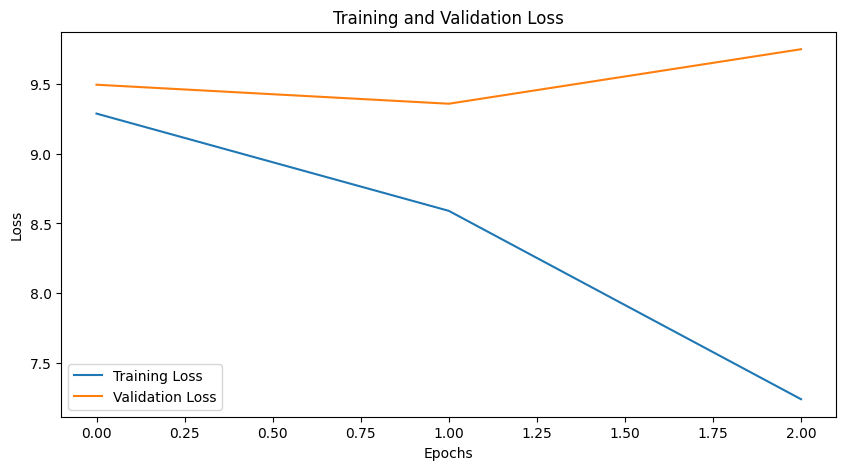

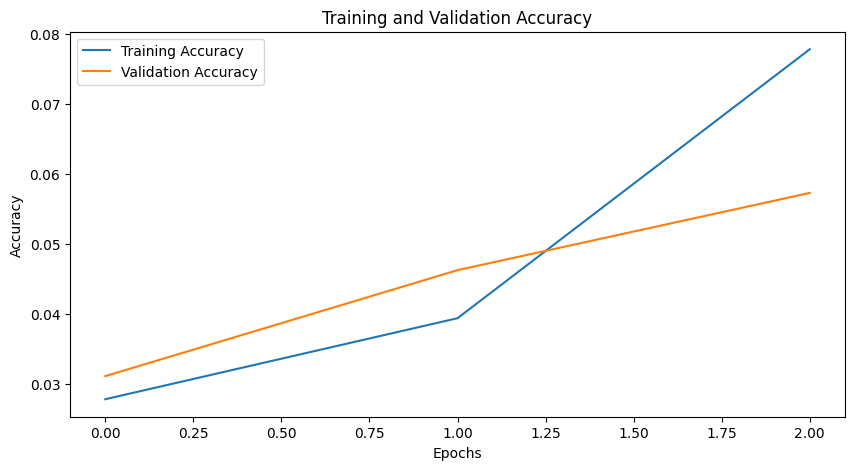

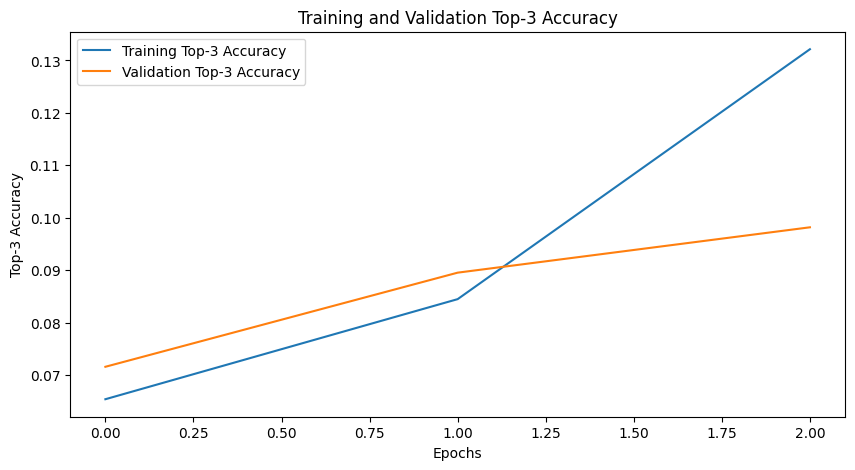

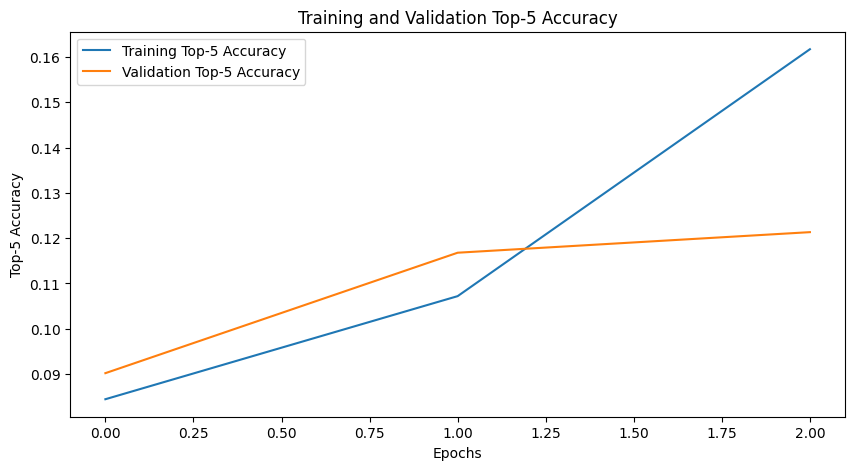

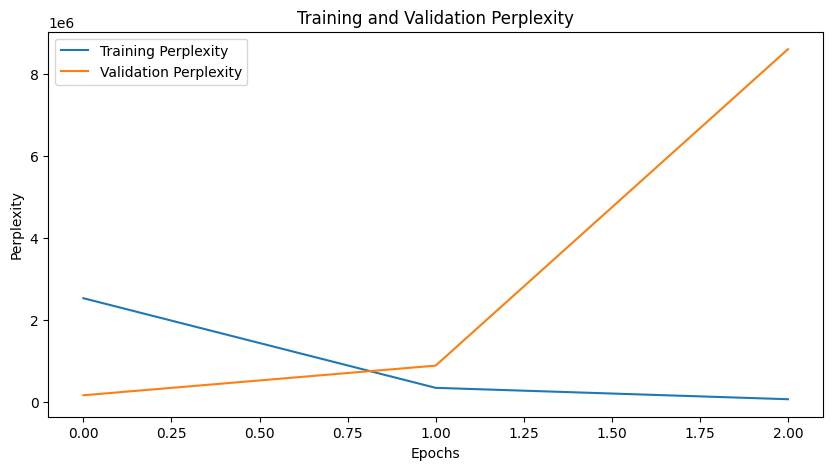

In [16]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Top-3 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_3_accuracy'], label='Training Top-3 Accuracy')
plt.plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy')
plt.title('Training and Validation Top-3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-3 Accuracy')
plt.legend()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_5_accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top_5_accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(history.history['perplexity'], label='Training Perplexity')
plt.plot(history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()




In [23]:
# Save the model architecture to JSON

ar_model.save('ar_model.keras')

# ar_model_json = ar_model.to_json()
# with open("ar_model.json", "w") as json_file:
#     json_file.write(ar_model_json)

# # Save the weights to HDF5
# ar_model.save_weights("ar_model.weights.h5")

# Save the tokenizer to a file
with open('ar_tokenizer.pkl', 'wb') as handle:
    pickle.dump(ar_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
max_sequence_len

289

In [27]:
loaded_ar_trie = load_trie('ar_trie.pkl')
loaded_ar_trie

In [29]:
loaded_ar_trie.autocomplete('ا')[:20]

['التي',
 'ان',
 'الذي',
 'الى',
 'الله',
 'العالم',
 'العام',
 'العربية',
 'السعودية',
 'المتحدة',
 'الذين',
 'اليوم',
 'السياحية',
 'المملكة',
 'الدول',
 'السياحة',
 'الماضي',
 'الوقت',
 'او',
 'الأول']

In [35]:
predict_top_five_words(ar_model, ar_tokenizer, )

['من', 'الروح', 'في', 'كانت', 'كان']

In [109]:
seed_text = 'صناعة ألماس شديد الشبه بالألماس الطبيعي بواسطة الليزر وبتكلفة قل'
seed_text

'صناعة ألماس شديد الشبه بالألماس الطبيعي بواسطة الليزر وبتكلفة'

In [98]:

token_list = ar_tokenizer.texts_to_sequences([seed_text])[0]
token_list


[363, 4742, 1695, 11045, 11046, 118, 2106, 11047, 4514]

In [105]:

MAX_WORDS_IN_CONTEXT = 20 - 1

padded_token_list = pad_sequences([token_list], maxlen=MAX_WORDS_IN_CONTEXT, padding='pre')
padded_token_list

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   363,  4742,  1695, 11045, 11046,   118,  2106, 11047,
         4514]], dtype=int32)

In [106]:

predicted = ar_model.predict(padded_token_list, verbose=0)[0]


In [107]:

print(predicted[::-1][:10])
print(predicted.shape)

[1.56709064e-07 8.97276138e-08 1.35556911e-05 1.09363218e-05
 3.71704971e-07 8.67402014e-06 2.06212499e-05 1.00826155e-05
 1.67146524e-07 9.89802447e-06]
(15511,)


In [108]:

top_indexes = np.argsort(predicted)[::-1][:20]

top_words = []
for index in top_indexes:
    for word, idx in ar_tokenizer.word_index.items():
        if idx == index:
            top_words.append(word)
            break

top_words

['مرة',
 'في',
 'ما',
 'يتم',
 'قليلة',
 'من',
 'والذي',
 'أن',
 'حتى',
 'الحالي',
 'البورصة',
 'الماء',
 'لم',
 'فيها',
 'لا',
 'تم',
 'العالمي',
 'للوقاية',
 'أحد',
 'بدء']